In [2]:
import pandas as pd
import os
import glob
# from cuml import TSNE, UMAP
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE as sklearn_tsne
from statannotations.Annotator import Annotator
from scipy.stats import mannwhitneyu
home = '/home/eloiseb/stanford_drive/data/Exosome/'
home = "/Users/eloiseberson/Google Drive/My Drive/data/Exosome/"

In [3]:
os.listdir(home + "Cohort Runs/Panel 1/")

['Panel 1 - Disabled Spots',
 'Panel 1 - Run data',
 'Panel 1 - Cut-Offs',
 'Panel 1 - Single-Particle data']

In [5]:
# load groundtruth
gt = pd.read_excel(os.path.join(home,'TPAD_CSF EV samples_koya.xlsx'))
gt = gt.loc[:, ['TPAD ID', 'Linkcode', 'Cohort', 'Diagnosis', 'PID 1-90']]
gt['PID 1-90'] = gt['PID 1-90'].astype('str')
gt

/Users/eloiseberson/anaconda3/envs/R_py/lib/python3.8/site-packages/openpyxl/reader/workbook.py:118: UserWarning: Print area cannot be set to Defined name: Table1[#All].
  warn(f"Print area cannot be set to Defined name: {defn.value}.")


,TPAD ID,Linkcode,Cohort,Diagnosis,PID 1-90
0,TPAD0473,141236,Poston,HC,1
1,TPAD0450,141091,Poston,HC,2
2,TPAD0494,141370,Poston,HC,3
3,TPAD0490,141361,Poston,HC,4
4,TPAD0471,141229,Poston,HC,5
...,...,...,...,...,...
85,TPAD0479,141312,Poston,PD-noMCI,86
86,TPAD0488,141352,Poston,PD-noMCI,87
87,TPAD0298,1013,ADRC,PD-noMCI,88
88,TPAD0318,1072,ADRC,PD-noMCI,89


In [ ]:
# load data
dico_panel2marker = {1:"A-Beta", 2:"Tau-5", 3:"A-Syn",4:"ApoE"}
df_tot = []
panel_id = 1
for panel_id in [1,2,3,4]:
    print(panel_id)
    panel_dir = os.path.join(home,'Cohort Runs',"Panel %s"%str(panel_id), 'Panel %s - Single-Particle data'%(str(panel_id)))
    file_list = [i for i in glob.glob(panel_dir+ "/Run */*") if '001_TotalParticles-' in i]
    file_list.sort()
    data_dict = {str(i+1)+'_'+str(k):v for i,d in enumerate([pd.read_excel(os.path.join(panel_dir, filename), sheet_name=None, header=None) for filename in file_list]) for k,v in d.items()}
    data_dict = {i:data_dict[i] for i in data_dict.keys() if all([j not in i for j in ['Parameters', 'Subpopulations']])}

    # join data into a dataframe
    data_list = []

    for person in data_dict.keys():
        data_sample = [data_dict[person].iloc[:, i*5:(i*5+5)].transpose().reset_index(drop=True).transpose() for i in range(int(data_dict[person].shape[1]/5))]
        data_sample = [d.iloc[1:, :] for d in data_sample]
        data_sample = [d[~d.isna().all(axis=1)] for d in data_sample]

        for i in range(len(data_sample)):
            data_sample[i].loc[:,5] = data_sample[i].iloc[0,1]
            data_sample[i].loc[:,0] = data_sample[i].loc[:,0].fillna(method="ffill")
            data_sample[i].columns = ['spot'] + data_sample[i].iloc[1,1:5].tolist() + ['marker']
            data_sample[i] = data_sample[i].iloc[2:,:]

        data_df = pd.concat(data_sample, axis=0)
        #filter by size
        data_exo = data_df.loc[(data_df.IM>=50) & (data_df.IM<=200), :].reset_index(drop=True)
        data_exo.loc[:, 'samples'] = person
        data_list += [data_exo]

    df = pd.concat(data_list, axis=0).reset_index(drop=True)
    df[['batch', 'samples']] = df.samples.str.split('_', expand=True)
    df["panel"] = panel_id

    df_tot.append(df)

In [ ]:
df = pd.concat(df_tot)
df[['CD47','PrP','IM', "Tau-5", "A-Syn", "ApoE"]] = df.loc[:, ['CD47','PrP','IM', "Tau-5", "A-Syn", "ApoE"]].astype('float')

df

In [59]:
df = pd.read_csv(home + "Cohort Runs/whole_dataset.csv", index_col=None)

/var/folders/yn/qvpxfrdd5870gxhq9hf9jvc40000gq/T/ipykernel_3386/3758246115.py:1: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(home + "Cohort Runs/whole_dataset.csv", index_col=None)


In [60]:
gt["PID 1-90"] = gt["PID 1-90"].astype(str)

df["samples"] = df['samples'].astype(str)

df_merge = df.merge(gt, left_on='samples', right_on='PID 1-90', how='left')


In [61]:
df_merge.Diagnosis.unique()

array(['HC', 'MCI', 'PD-noMCI', 'AD', 'PDD', 'PD-MCI', nan], dtype=object)

In [63]:
df_merge[df_merge.Diagnosis.isna()]

,Unnamed: 0,spot,A-Beta,CD47,PrP,IM,marker,samples,batch,panel,Tau-5,A-Syn,ApoE,TPAD ID,Linkcode,Cohort,Diagnosis,PID 1-90
219143,219143,Spot4,0.0,0.0,0.0,54.800081,CD63,Pooled Control,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
219144,219144,Spot4,0.0,0.0,0.0,54.520850,CD63,Pooled Control,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
219145,219145,Spot4,0.0,0.0,738.0,51.035174,CD63,Pooled Control,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
219146,219146,Spot4,0.0,0.0,0.0,54.548411,CD63,Pooled Control,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
219147,219147,Spot4,0.0,0.0,0.0,57.093529,CD63,Pooled Control,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6419106,1750389,Spot12,NaN,0.0,0.0,54.054744,MIgG,Pooled Control,6,4,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN
6419107,1750390,Spot12,NaN,0.0,0.0,53.635352,MIgG,Pooled Control,6,4,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN
6419108,1750391,Spot12,NaN,0.0,0.0,51.838642,MIgG,Pooled Control,6,4,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN
6419109,1750392,Spot12,NaN,0.0,0.0,52.391660,MIgG,Pooled Control,6,4,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN


In [64]:
df.IM.min()

50.00000088073453

In [65]:
control = df[df.samples == "Pooled Control"]
cont_size = control.groupby(["panel", "batch","marker", "spot"]).size().reset_index()
cont_size.columns = ["panel", "batch","marker", "spot", "# particles"]
cont_size

,panel,batch,marker,spot,# particles
0,1,1,CD63,Spot4,476
1,1,1,CD63,Spot5,512
2,1,1,CD63,Spot6,443
3,1,1,CD81,Spot1,2653
4,1,1,CD81,Spot2,2374
...,...,...,...,...,...
219,4,6,CD9,Spot8,3650
220,4,6,CD9,Spot9,3996
221,4,6,MIgG,Spot10,12
222,4,6,MIgG,Spot11,8


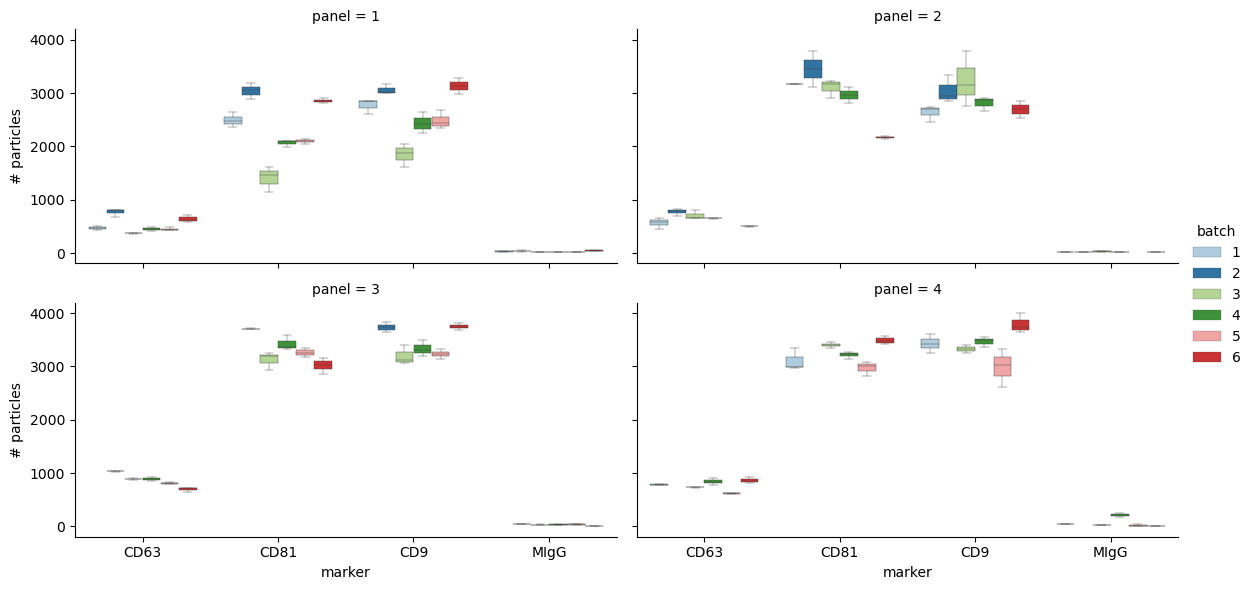

In [32]:
control = df[df.samples == "Pooled Control"]
cont_size = control.groupby(["panel", "batch","marker", "spot"]).size().reset_index()
cont_size.columns = ["panel", "batch","marker", "spot", "# particles"]
#cont_size["batch"] = 
x = "marker"
hue = "batch"
y = "# particles"
col = "panel"
g = sns.catplot(
    data=cont_size, 
    kind="box",
    x=x, y=y, hue=hue,col=col,col_wrap=2,
    palette="Paired",  height=3, aspect=2,
    linewidth=0.3,
    #alpha=.6,
    #sharex=True,
    #sharey=True,
    
)
# ax = sns.boxplot(data=cont_size, x="panel", y="# particles", hue="batch", palette="Paired")
# ax.legend(bbox_to_anchor=(1,1))

In [ ]:
cont_size[(cont_size.panel ==4)& (cont_size.marker == "CD81")].groupby(["batch"])["# particles"].mean()

# Remove Pooled Control

In [168]:

df = df_merge[df_merge.samples !="Pooled Control"]
df

,Unnamed: 0,spot,A-Beta,CD47,PrP,IM,marker,samples,batch,panel,Tau-5,A-Syn,ApoE,TPAD ID,Linkcode,Cohort,Diagnosis,PID 1-90
0,0,Spot4,0.0,0.0,0.0,50.350120,CD63,9,1,1,NaN,NaN,NaN,TPAD0491,141362,Poston,HC,9
1,1,Spot4,0.0,0.0,624.0,50.389418,CD63,9,1,1,NaN,NaN,NaN,TPAD0491,141362,Poston,HC,9
2,2,Spot4,0.0,0.0,0.0,50.520433,CD63,9,1,1,NaN,NaN,NaN,TPAD0491,141362,Poston,HC,9
3,3,Spot4,0.0,0.0,0.0,51.116215,CD63,9,1,1,NaN,NaN,NaN,TPAD0491,141362,Poston,HC,9
4,4,Spot4,0.0,0.0,491.0,55.023671,CD63,9,1,1,NaN,NaN,NaN,TPAD0491,141362,Poston,HC,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6394615,1725898,Spot12,NaN,0.0,0.0,56.603524,MIgG,58,6,4,NaN,NaN,0.0,TPAD0367,1211,ADRC,MCI,58
6394616,1725899,Spot12,NaN,0.0,0.0,51.135725,MIgG,58,6,4,NaN,NaN,0.0,TPAD0367,1211,ADRC,MCI,58
6394617,1725900,Spot12,NaN,0.0,0.0,51.770379,MIgG,58,6,4,NaN,NaN,0.0,TPAD0367,1211,ADRC,MCI,58
6394618,1725901,Spot12,NaN,0.0,543.0,51.780516,MIgG,58,6,4,NaN,NaN,0.0,TPAD0367,1211,ADRC,MCI,58


In [169]:
mapping = {"MCI":"AD", "PD-noMCI":"PDD", "PD-MCI":"PDD", "HC":"HC", "AD":"AD", "PDD":"PDD"}
df["Diagnosis"] = df["Diagnosis"].map(mapping).values

/var/folders/yn/qvpxfrdd5870gxhq9hf9jvc40000gq/T/ipykernel_3386/4001353654.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Diagnosis"] = df["Diagnosis"].map(mapping).values


In [170]:
df.Diagnosis.unique()

array(['HC', 'AD', 'PDD'], dtype=object)

In [75]:
# distribution plots by batch and by groups
marker = ['A-Beta', 'CD47', 'PrP', "Tau-5", "ApoE", "A-Syn"]
groupby_cols = ['panel', 'samples', "marker", "spot"]
df_plt = (df.groupby(groupby_cols)[marker].apply(lambda x: (x>0).sum())/df.groupby(groupby_cols).count().loc[:, marker]*100).reset_index()
df_plt = df_plt.melt(groupby_cols)
df_plt.head(3)

,panel,samples,marker,spot,variable,value
0,1,1,CD63,Spot4,A-Beta,2.133713
1,1,1,CD63,Spot5,A-Beta,1.032448
2,1,1,CD63,Spot6,A-Beta,1.312336


/Users/eloiseberson/anaconda3/envs/R_py/lib/python3.8/site-packages/seaborn/algorithms.py:98: RuntimeWarning: Mean of empty slice
  resampler = integers(0, n_units, n_units, dtype=np.intp)
/Users/eloiseberson/anaconda3/envs/R_py/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1560: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a,
/Users/eloiseberson/anaconda3/envs/R_py/lib/python3.8/site-packages/seaborn/algorithms.py:98: RuntimeWarning: Mean of empty slice
  resampler = integers(0, n_units, n_units, dtype=np.intp)
/Users/eloiseberson/anaconda3/envs/R_py/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1560: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a,
/Users/eloiseberson/anaconda3/envs/R_py/lib/python3.8/site-packages/seaborn/algorithms.py:98: RuntimeWarning: Mean of empty slice
  resampler = integers(0, n_units, n_units, dtype=np.intp)
/Users/eloiseberson/anaconda3/envs/R_py/lib/python3.8/site-packages/numpy/lib/n

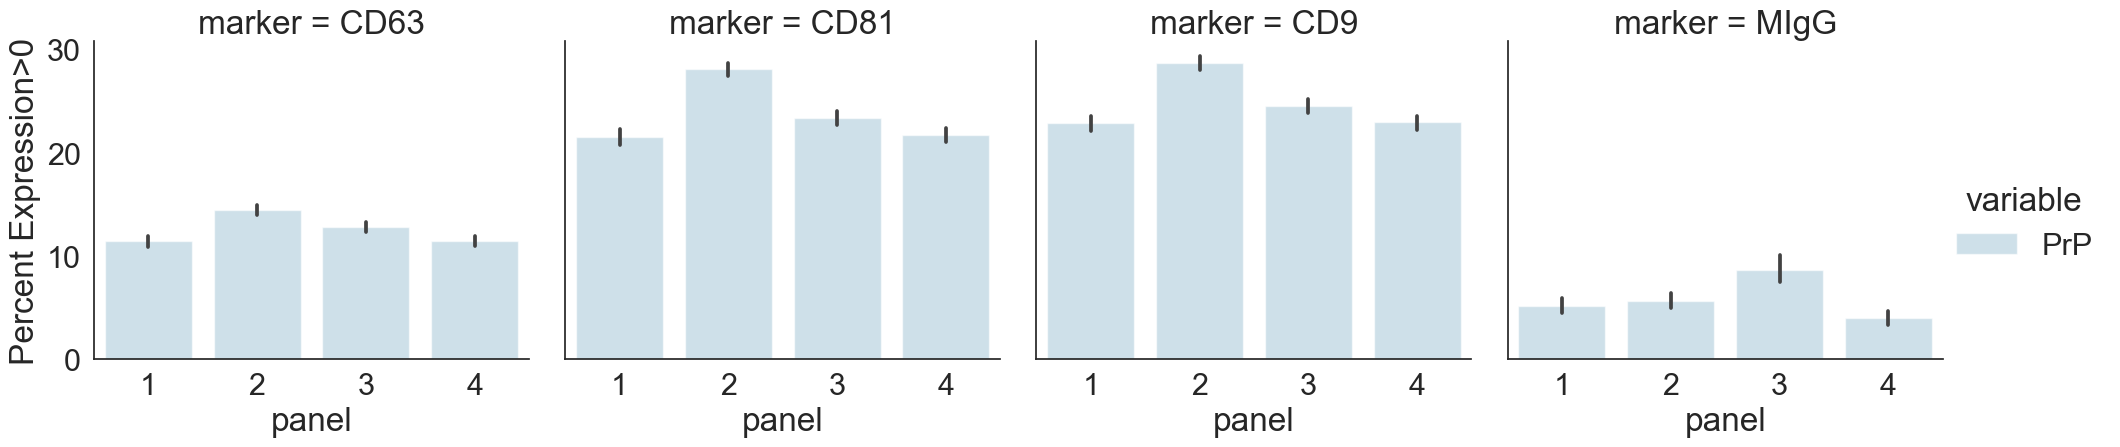

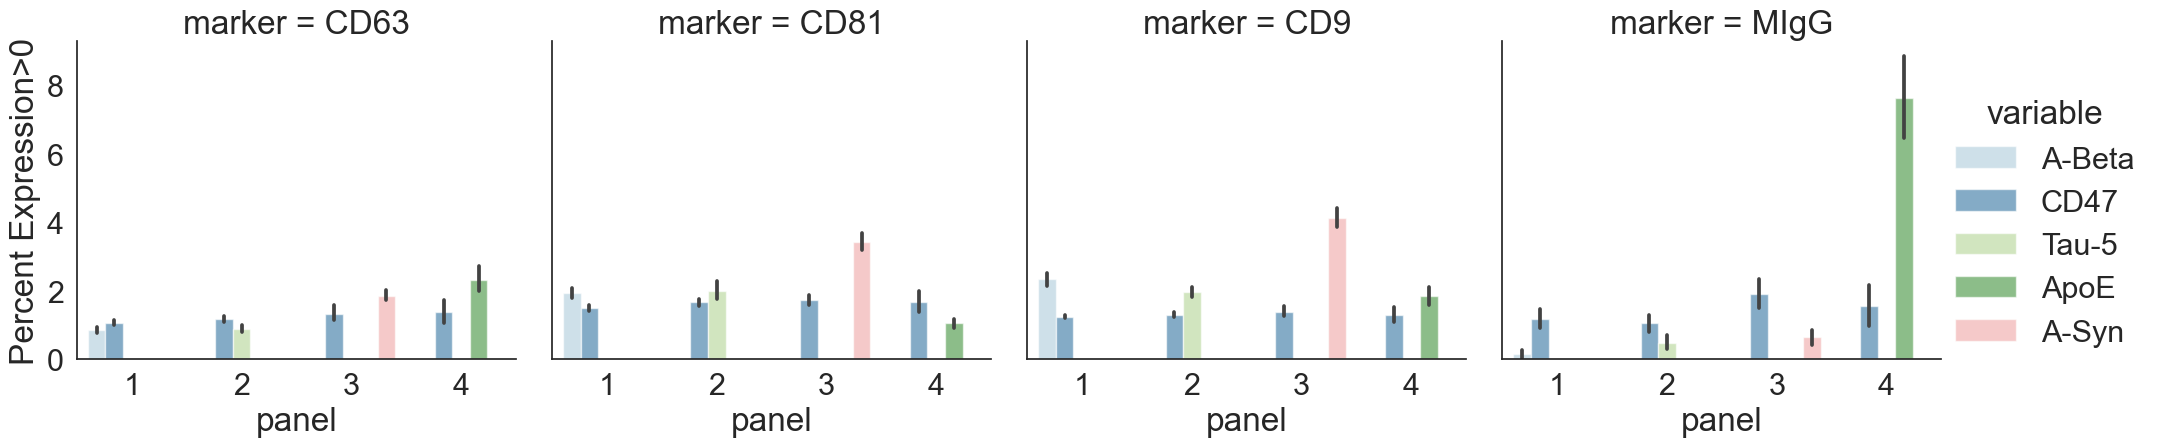

In [76]:
x="panel"
sns.set(font_scale=2, style="white")
y="Percent Expression>0"
df_plt.rename({"value":y}, axis=1, inplace=True)
g = sns.catplot(
    data=df_plt.loc[df_plt.variable=='PrP', :], 
    kind="bar",
    x=x, y=y, hue="variable",col="marker",#col_wrap=2,
    palette="Paired", alpha=.6, height=5, aspect=1,
    #sharex=True,
    sharey=True,
    
)
g = sns.catplot(
    data=df_plt.loc[df_plt.variable!='PrP', :], 
    kind="bar",
    x=x, y=y, hue="variable",col="marker",#col_wrap=2,
    palette="Paired", alpha=.6, height=5, aspect=1,
    #sharex=True,
    sharey=True,
    
)
# g.despine(left=True)
# g.set_axis_labels(x, "Percent Expression>0")

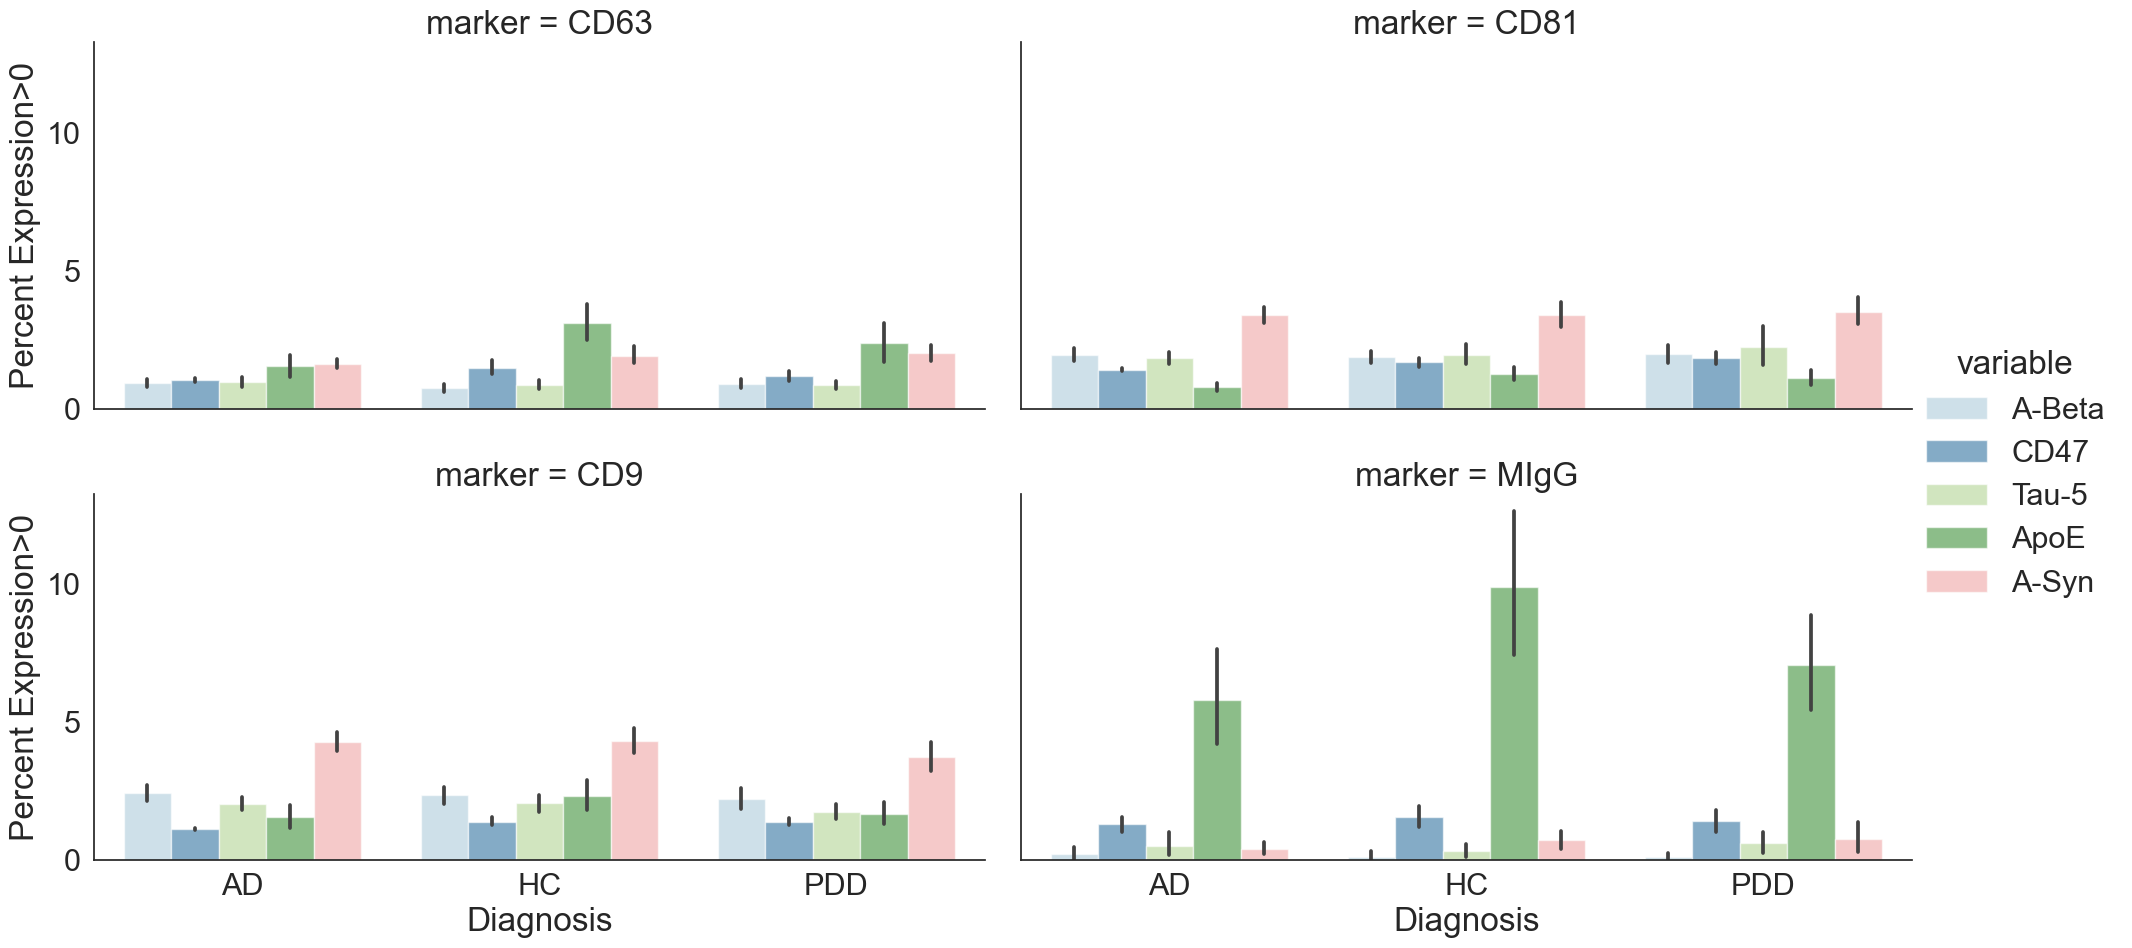

In [81]:
groupby_cols = ['Diagnosis', "panel", 'samples', "marker", "spot"]
df_plt = (df.groupby(groupby_cols)[marker].apply(lambda x: (x>0).sum())/df.groupby(groupby_cols).count().loc[:, marker]*100).reset_index()
df_plt = df_plt.melt(groupby_cols)
df_plt.head(3)
x="Diagnosis"
sns.set(font_scale=2, style="white")
y="Percent Expression>0"
df_plt.rename({"value":y}, axis=1, inplace=True)
# g = sns.catplot(
#     data=df_plt.loc[df_plt.variable=='PrP', :], 
#     kind="bar",
#     x=x, y=y, hue="variable",col="marker",#col_wrap=2,
#     palette="Paired", alpha=.6, height=5, aspect=1.5,
#     #sharex=True,
#     sharey=True,
    
# )
g = sns.catplot(
    data=df_plt.loc[df_plt.variable!='PrP', :], 
    kind="bar",
    x=x, y=y, hue="variable",col="marker",col_wrap=2,
    palette="Paired", alpha=.6, height=5, aspect=2,
    #sharex=True,
    sharey=True,
    
)

In [89]:
df_plt = df.groupby(groupby_cols).size().reset_index()
df_plt = df_plt.melt(groupby_cols)
df_plt

,Diagnosis,panel,samples,marker,spot,variable,value
0,AD,1,31,CD63,Spot4,0,561
1,AD,1,31,CD63,Spot5,0,509
2,AD,1,31,CD63,Spot6,0,555
3,AD,1,31,CD81,Spot1,0,2838
4,AD,1,31,CD81,Spot2,0,2791
...,...,...,...,...,...,...,...
3461,PDD,4,90,CD9,Spot8,0,3105
3462,PDD,4,90,CD9,Spot9,0,3254
3463,PDD,4,90,MIgG,Spot10,0,18
3464,PDD,4,90,MIgG,Spot11,0,24


<AxesSubplot: xlabel='Diagnosis', ylabel='# of particles'>

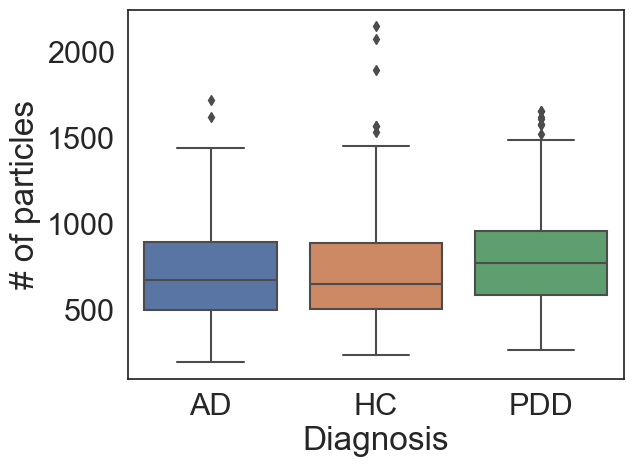

In [92]:
sns.boxplot(data=df_plt[df_plt.marker=="CD63"], x=x, y=y)

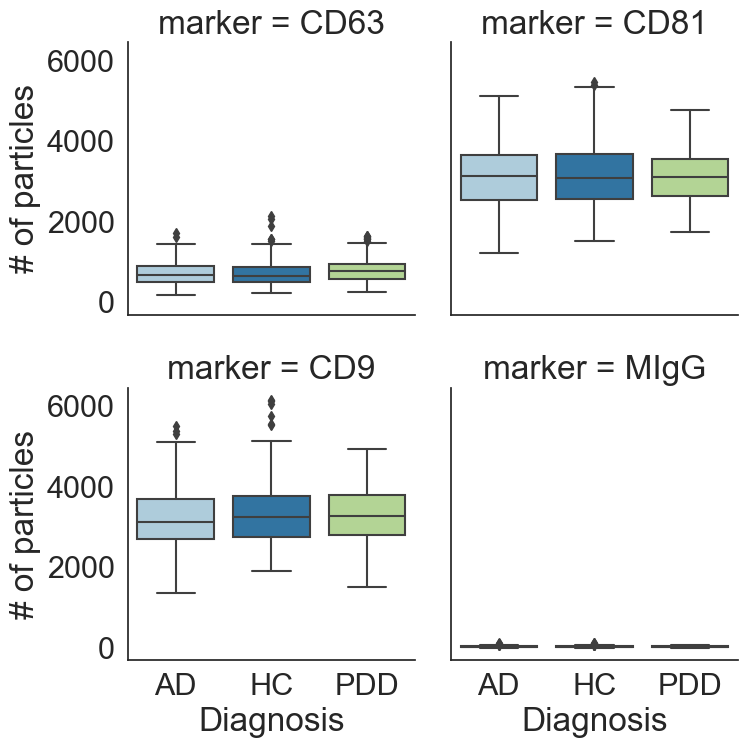

In [96]:
groupby_cols = ['Diagnosis', "panel", 'samples', "marker", "spot"]
df_plt = df.groupby(groupby_cols).size().reset_index()
df_plt = df_plt.melt(groupby_cols)
df_plt.head(3)
x="Diagnosis"
sns.set(font_scale=2, style="white")
y="# of particles"
df_plt.rename({"value":y}, axis=1, inplace=True)
# g = sns.catplot(
#     data=df_plt.loc[df_plt.variable=='PrP', :], 
#     kind="bar",
#     x=x, y=y, hue="variable",col="marker",#col_wrap=2,
#     palette="Paired", alpha=.6, height=5, aspect=1.5,
#     #sharex=True,
#     sharey=True,
    
# )
g = sns.catplot(
    data=df_plt.loc[df_plt.variable!='PrP', :], 
    kind="box",
    x=x, y=y,col="marker",col_wrap=2,
    palette="Paired", #alpha=.6, 
    height=4, aspect=1,
    #sharex=True,
    #sharey=True,
    
)

In [ ]:
# mark = "CD81"
# var="Tau-5"
# df_ = df_plt[(df_plt.marker==mark) & (df_plt.variable==var)]
# x="Diagnosis"
# sns.set(font_scale=2, style="white")
# y="Percent Expression>0"
# g = sns.catplot(
#     data=df_, 
#     kind="bar",
#     x=x, y=y, hue="variable",#col="panel",#col_wrap=2,
#     palette="Paired", alpha=.6, height=5, aspect=2,
#     #sharex=True,
#     sharey=True,
    
# )

# pairs = [("PD-MCI", i) for i in df_plt.Diagnosis.unique()]

# #for name,ax in g.axes_dict.items():
# if True:
#         ax = g.ax
# # subset the table otherwise the stats were calculated on the whole dataset
#         annot = Annotator(ax, pairs, data=df_, x=x, y=y) 
#         annot.configure(test='Mann-Whitney', text_format='star', loc='inside', verbose=2)
#         annot.apply_test().annotate()
# g.fig.subplots_adjust(top=0.9) # adjust the Figure in rp
# g.fig.suptitle(mark +' / '+ var)

In [107]:
# #from sklearn.neighbors import KNeighborsClassifier
# from sklearn.cluster import KMeans
# n_panel = 2
# n_clusters = 4 + n_panel*4
# kmeans = KMeans(
#         init="random",
#         n_clusters=n_clusters,
#         n_init=10,
#         max_iter=300,
#         random_state=42
#            )
# cols = ['A-Beta', 'CD47', 'PrP', "Tau-5", "IM"]
# kmeans.fit(df[cols].fillna(0))
# clusters = kmeans.labels_
# df["label"] = clusters

In [130]:
df

,Unnamed: 0,spot,A-Beta,CD47,PrP,IM,marker,samples,batch,panel,Tau-5,A-Syn,ApoE,TPAD ID,Linkcode,Cohort,Diagnosis,PID 1-90
0,0,Spot4,0.0,0.0,0.0,50.350120,CD63,9,1,1,NaN,NaN,NaN,TPAD0491,141362,Poston,HC,9
1,1,Spot4,0.0,0.0,624.0,50.389418,CD63,9,1,1,NaN,NaN,NaN,TPAD0491,141362,Poston,HC,9
2,2,Spot4,0.0,0.0,0.0,50.520433,CD63,9,1,1,NaN,NaN,NaN,TPAD0491,141362,Poston,HC,9
3,3,Spot4,0.0,0.0,0.0,51.116215,CD63,9,1,1,NaN,NaN,NaN,TPAD0491,141362,Poston,HC,9
4,4,Spot4,0.0,0.0,491.0,55.023671,CD63,9,1,1,NaN,NaN,NaN,TPAD0491,141362,Poston,HC,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6394615,1725898,Spot12,NaN,0.0,0.0,56.603524,MIgG,58,6,4,NaN,NaN,0.0,TPAD0367,1211,ADRC,AD,58
6394616,1725899,Spot12,NaN,0.0,0.0,51.135725,MIgG,58,6,4,NaN,NaN,0.0,TPAD0367,1211,ADRC,AD,58
6394617,1725900,Spot12,NaN,0.0,0.0,51.770379,MIgG,58,6,4,NaN,NaN,0.0,TPAD0367,1211,ADRC,AD,58
6394618,1725901,Spot12,NaN,0.0,543.0,51.780516,MIgG,58,6,4,NaN,NaN,0.0,TPAD0367,1211,ADRC,AD,58


In [196]:
#handmade combinations
import itertools
import numpy as np
cols = ['PrP', 'CD47','A-Beta', "Tau-5", "ApoE", "A-Syn"]#, "IM"]
comb_ = []
for L in range(len(cols) + 1):
    for subset in itertools.combinations(cols, L):
        comb_.append(subset)
coloc = []
# df_def = pd.DataFrame(columns=["cluster"] +cols)
null = []
df[cols] = df[cols].astype(float)
df_ = df.fillna(0).loc[df[cols].sum(1)>0,:]
df_.reset_index(inplace=True, drop=True)


non_overlapping = False
for mm in comb_:
    print(mm)
    if len(mm)>0:
        zero_mar = [it for it in cols if it not in mm]
        pos = [it for it in mm]

        if len(zero_mar)>0:
            if non_overlapping:
                index1 = np.where((df_[zero_mar]==0).all(axis=1))[0]
                index2 =  np.where((df_[pos]>0).all(axis=1))[0]
                index = np.intersect1d(index1,index2)
            else:
                index =  np.where((df_[pos]>0).all(axis=1))[0]

            #index = [it for it in index1 if it in index2]
        else:
            index = np.where((df_[pos]>0).all(axis=1))[0]

        tmp = df_.iloc[index,:].copy()
        
        #if len(tmp)>0:
        tmp["cluster"] = "/".join(pos) + "+"
        coloc.append(tmp)
        if len(tmp) ==0:
            null.append("/".join(pos) + "+")

/var/folders/yn/qvpxfrdd5870gxhq9hf9jvc40000gq/T/ipykernel_3386/3761372640.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[cols] = df[cols].astype(float)


()
('PrP',)
('CD47',)
('A-Beta',)
('Tau-5',)
('ApoE',)
('A-Syn',)
('PrP', 'CD47')
('PrP', 'A-Beta')
('PrP', 'Tau-5')
('PrP', 'ApoE')
('PrP', 'A-Syn')
('CD47', 'A-Beta')
('CD47', 'Tau-5')
('CD47', 'ApoE')
('CD47', 'A-Syn')
('A-Beta', 'Tau-5')
('A-Beta', 'ApoE')
('A-Beta', 'A-Syn')
('Tau-5', 'ApoE')
('Tau-5', 'A-Syn')
('ApoE', 'A-Syn')
('PrP', 'CD47', 'A-Beta')
('PrP', 'CD47', 'Tau-5')
('PrP', 'CD47', 'ApoE')
('PrP', 'CD47', 'A-Syn')
('PrP', 'A-Beta', 'Tau-5')
('PrP', 'A-Beta', 'ApoE')
('PrP', 'A-Beta', 'A-Syn')
('PrP', 'Tau-5', 'ApoE')
('PrP', 'Tau-5', 'A-Syn')
('PrP', 'ApoE', 'A-Syn')
('CD47', 'A-Beta', 'Tau-5')
('CD47', 'A-Beta', 'ApoE')
('CD47', 'A-Beta', 'A-Syn')
('CD47', 'Tau-5', 'ApoE')
('CD47', 'Tau-5', 'A-Syn')
('CD47', 'ApoE', 'A-Syn')
('A-Beta', 'Tau-5', 'ApoE')
('A-Beta', 'Tau-5', 'A-Syn')
('A-Beta', 'ApoE', 'A-Syn')
('Tau-5', 'ApoE', 'A-Syn')
('PrP', 'CD47', 'A-Beta', 'Tau-5')
('PrP', 'CD47', 'A-Beta', 'ApoE')
('PrP', 'CD47', 'A-Beta', 'A-Syn')
('PrP', 'CD47', 'Tau-5', 'ApoE

In [197]:
ratio_def = len(df_)/len(df)
ratio_def

0.2573303342601662

In [198]:
null

['A-Beta/Tau-5+',
 'A-Beta/ApoE+',
 'A-Beta/A-Syn+',
 'Tau-5/ApoE+',
 'Tau-5/A-Syn+',
 'ApoE/A-Syn+',
 'PrP/A-Beta/Tau-5+',
 'PrP/A-Beta/ApoE+',
 'PrP/A-Beta/A-Syn+',
 'PrP/Tau-5/ApoE+',
 'PrP/Tau-5/A-Syn+',
 'PrP/ApoE/A-Syn+',
 'CD47/A-Beta/Tau-5+',
 'CD47/A-Beta/ApoE+',
 'CD47/A-Beta/A-Syn+',
 'CD47/Tau-5/ApoE+',
 'CD47/Tau-5/A-Syn+',
 'CD47/ApoE/A-Syn+',
 'A-Beta/Tau-5/ApoE+',
 'A-Beta/Tau-5/A-Syn+',
 'A-Beta/ApoE/A-Syn+',
 'Tau-5/ApoE/A-Syn+',
 'PrP/CD47/A-Beta/Tau-5+',
 'PrP/CD47/A-Beta/ApoE+',
 'PrP/CD47/A-Beta/A-Syn+',
 'PrP/CD47/Tau-5/ApoE+',
 'PrP/CD47/Tau-5/A-Syn+',
 'PrP/CD47/ApoE/A-Syn+',
 'PrP/A-Beta/Tau-5/ApoE+',
 'PrP/A-Beta/Tau-5/A-Syn+',
 'PrP/A-Beta/ApoE/A-Syn+',
 'PrP/Tau-5/ApoE/A-Syn+',
 'CD47/A-Beta/Tau-5/ApoE+',
 'CD47/A-Beta/Tau-5/A-Syn+',
 'CD47/A-Beta/ApoE/A-Syn+',
 'CD47/Tau-5/ApoE/A-Syn+',
 'A-Beta/Tau-5/ApoE/A-Syn+',
 'PrP/CD47/A-Beta/Tau-5/ApoE+',
 'PrP/CD47/A-Beta/Tau-5/A-Syn+',
 'PrP/CD47/A-Beta/ApoE/A-Syn+',
 'PrP/CD47/Tau-5/ApoE/A-Syn+',
 'PrP/A-Beta/Ta

In [199]:
coloc_df = pd.concat(coloc)
coloc_df

,Unnamed: 0,spot,A-Beta,CD47,PrP,IM,marker,samples,batch,panel,Tau-5,A-Syn,ApoE,TPAD ID,Linkcode,Cohort,Diagnosis,PID 1-90,cluster
0,1,Spot4,0.0,0.0,624.0,50.389418,CD63,9,1,1,0.0,0.0,0.0,TPAD0491,141362,Poston,HC,9,PrP+
1,4,Spot4,0.0,0.0,491.0,55.023671,CD63,9,1,1,0.0,0.0,0.0,TPAD0491,141362,Poston,HC,9,PrP+
2,33,Spot4,0.0,0.0,503.0,51.658392,CD63,9,1,1,0.0,0.0,0.0,TPAD0491,141362,Poston,HC,9,PrP+
3,36,Spot4,0.0,0.0,614.0,53.533037,CD63,9,1,1,0.0,0.0,0.0,TPAD0491,141362,Poston,HC,9,PrP+
4,44,Spot4,0.0,0.0,467.0,50.785663,CD63,9,1,1,0.0,0.0,0.0,TPAD0491,141362,Poston,HC,9,PrP+
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1158629,1673711,Spot3,0.0,318.0,466.0,51.233810,CD81,66,6,3,0.0,324.0,0.0,TPAD0445,141070,Poston,PDD,66,PrP/CD47/A-Syn+
1158835,1674328,Spot3,0.0,318.0,530.0,60.900835,CD81,66,6,3,0.0,323.0,0.0,TPAD0445,141070,Poston,PDD,66,PrP/CD47/A-Syn+
1158839,1674332,Spot3,0.0,250.0,774.0,78.601611,CD81,66,6,3,0.0,398.0,0.0,TPAD0445,141070,Poston,PDD,66,PrP/CD47/A-Syn+
1161177,1681245,Spot8,0.0,295.0,446.0,56.777675,CD9,66,6,3,0.0,470.0,0.0,TPAD0445,141070,Poston,PDD,66,PrP/CD47/A-Syn+


/var/folders/yn/qvpxfrdd5870gxhq9hf9jvc40000gq/T/ipykernel_3386/1506386790.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  cbar_ax.set_yticklabels(['0', '1'])


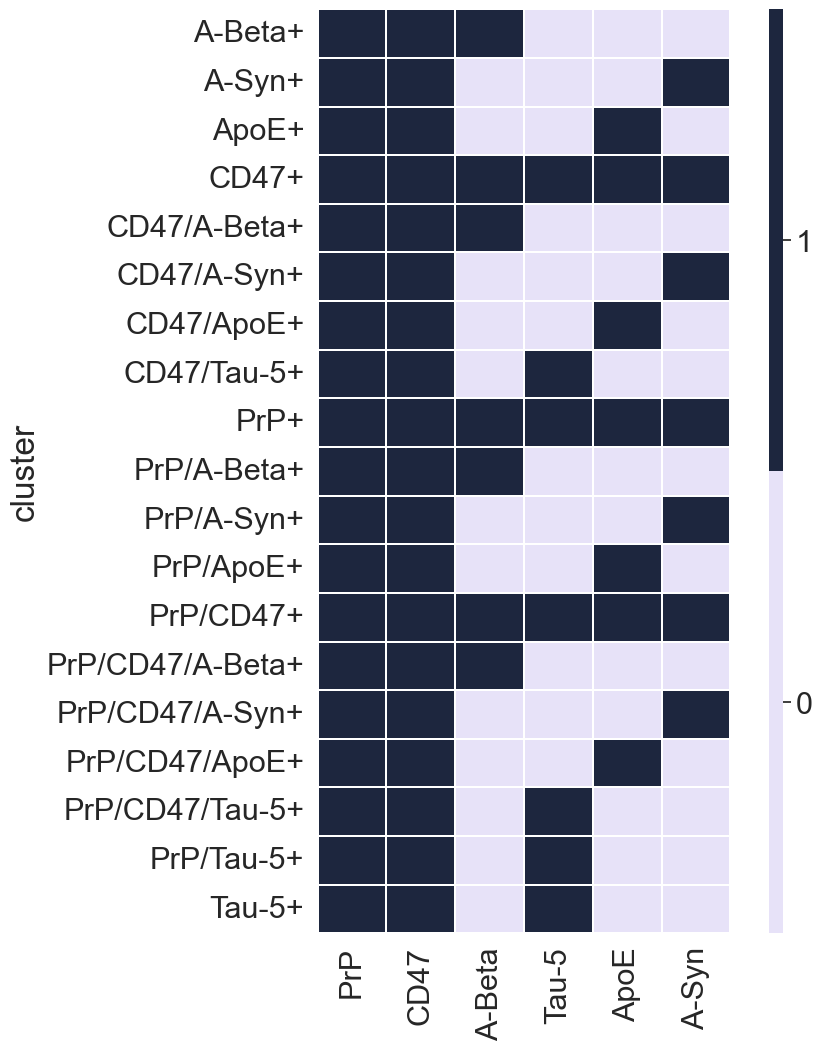

In [200]:
from matplotlib.colors import ListedColormap
mat = coloc_df[cols+["cluster"]].groupby(["cluster"]).mean()
mat[mat>0] = 1
cmap = sns.cubehelix_palette(start=2.8, rot=.1, light=0.9, n_colors=2)
grid_kws = {'width_ratios': (0.9, 0.03), 'wspace': 0.18}
fig, (ax, cbar_ax) = plt.subplots(1, 2, figsize=(6, 12), gridspec_kw=grid_kws)
sns.heatmap(mat, cmap=ListedColormap(cmap), ax=ax,cbar_ax=cbar_ax,linewidth=0.2)
cbar_ax.set_yticklabels(['0', '1'])
cbar_ax.yaxis.set_ticks([ 0.25, 0.75])

Text(0.5, 1.0, 'Distribution of the single exomes')

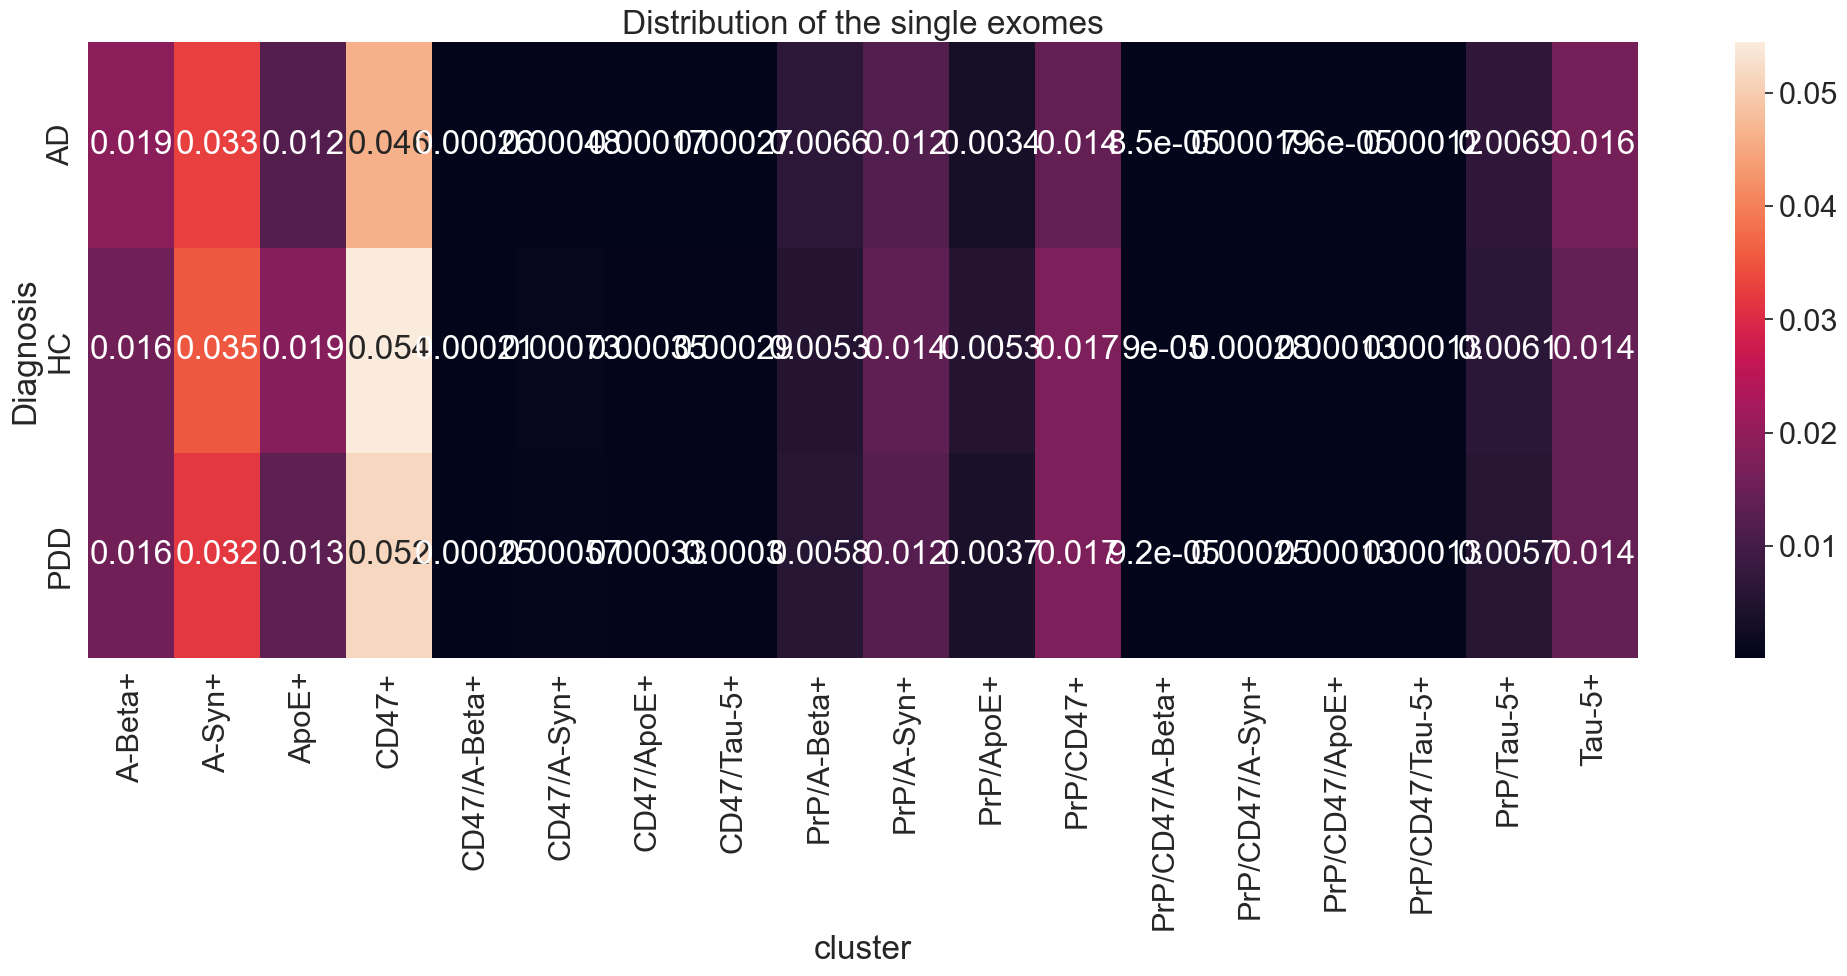

In [201]:
repart = coloc_df.groupby(["cluster", "Diagnosis"]).size().unstack().fillna(0)
repart = repart.div(repart.sum(0), axis=1)
fig, ax = plt.subplots(figsize=(25, 8))
sns.heatmap(repart.T.drop("PrP+", axis=1),
            annot=True, ax=ax)
ax.set_title("Distribution of the single exomes")

In [202]:
mean_express = coloc_df.groupby(["cluster", "Diagnosis", "samples", "spot"])["IM"].mean()#.unstack().fillna(0)


df_plot = coloc_df.reset_index().groupby(["cluster", "Diagnosis", "samples", "spot"])[cols].mean().reset_index().melt(["cluster", "Diagnosis", "samples", "spot"]).fillna(0)
y = "Mean expression"
df_plot.rename({"value":y}, inplace=True, axis=1)
df_plot[y].replace([np.inf, -np.inf], 0, inplace=True)
df_plot[y] = df_plot[y].astype(float)



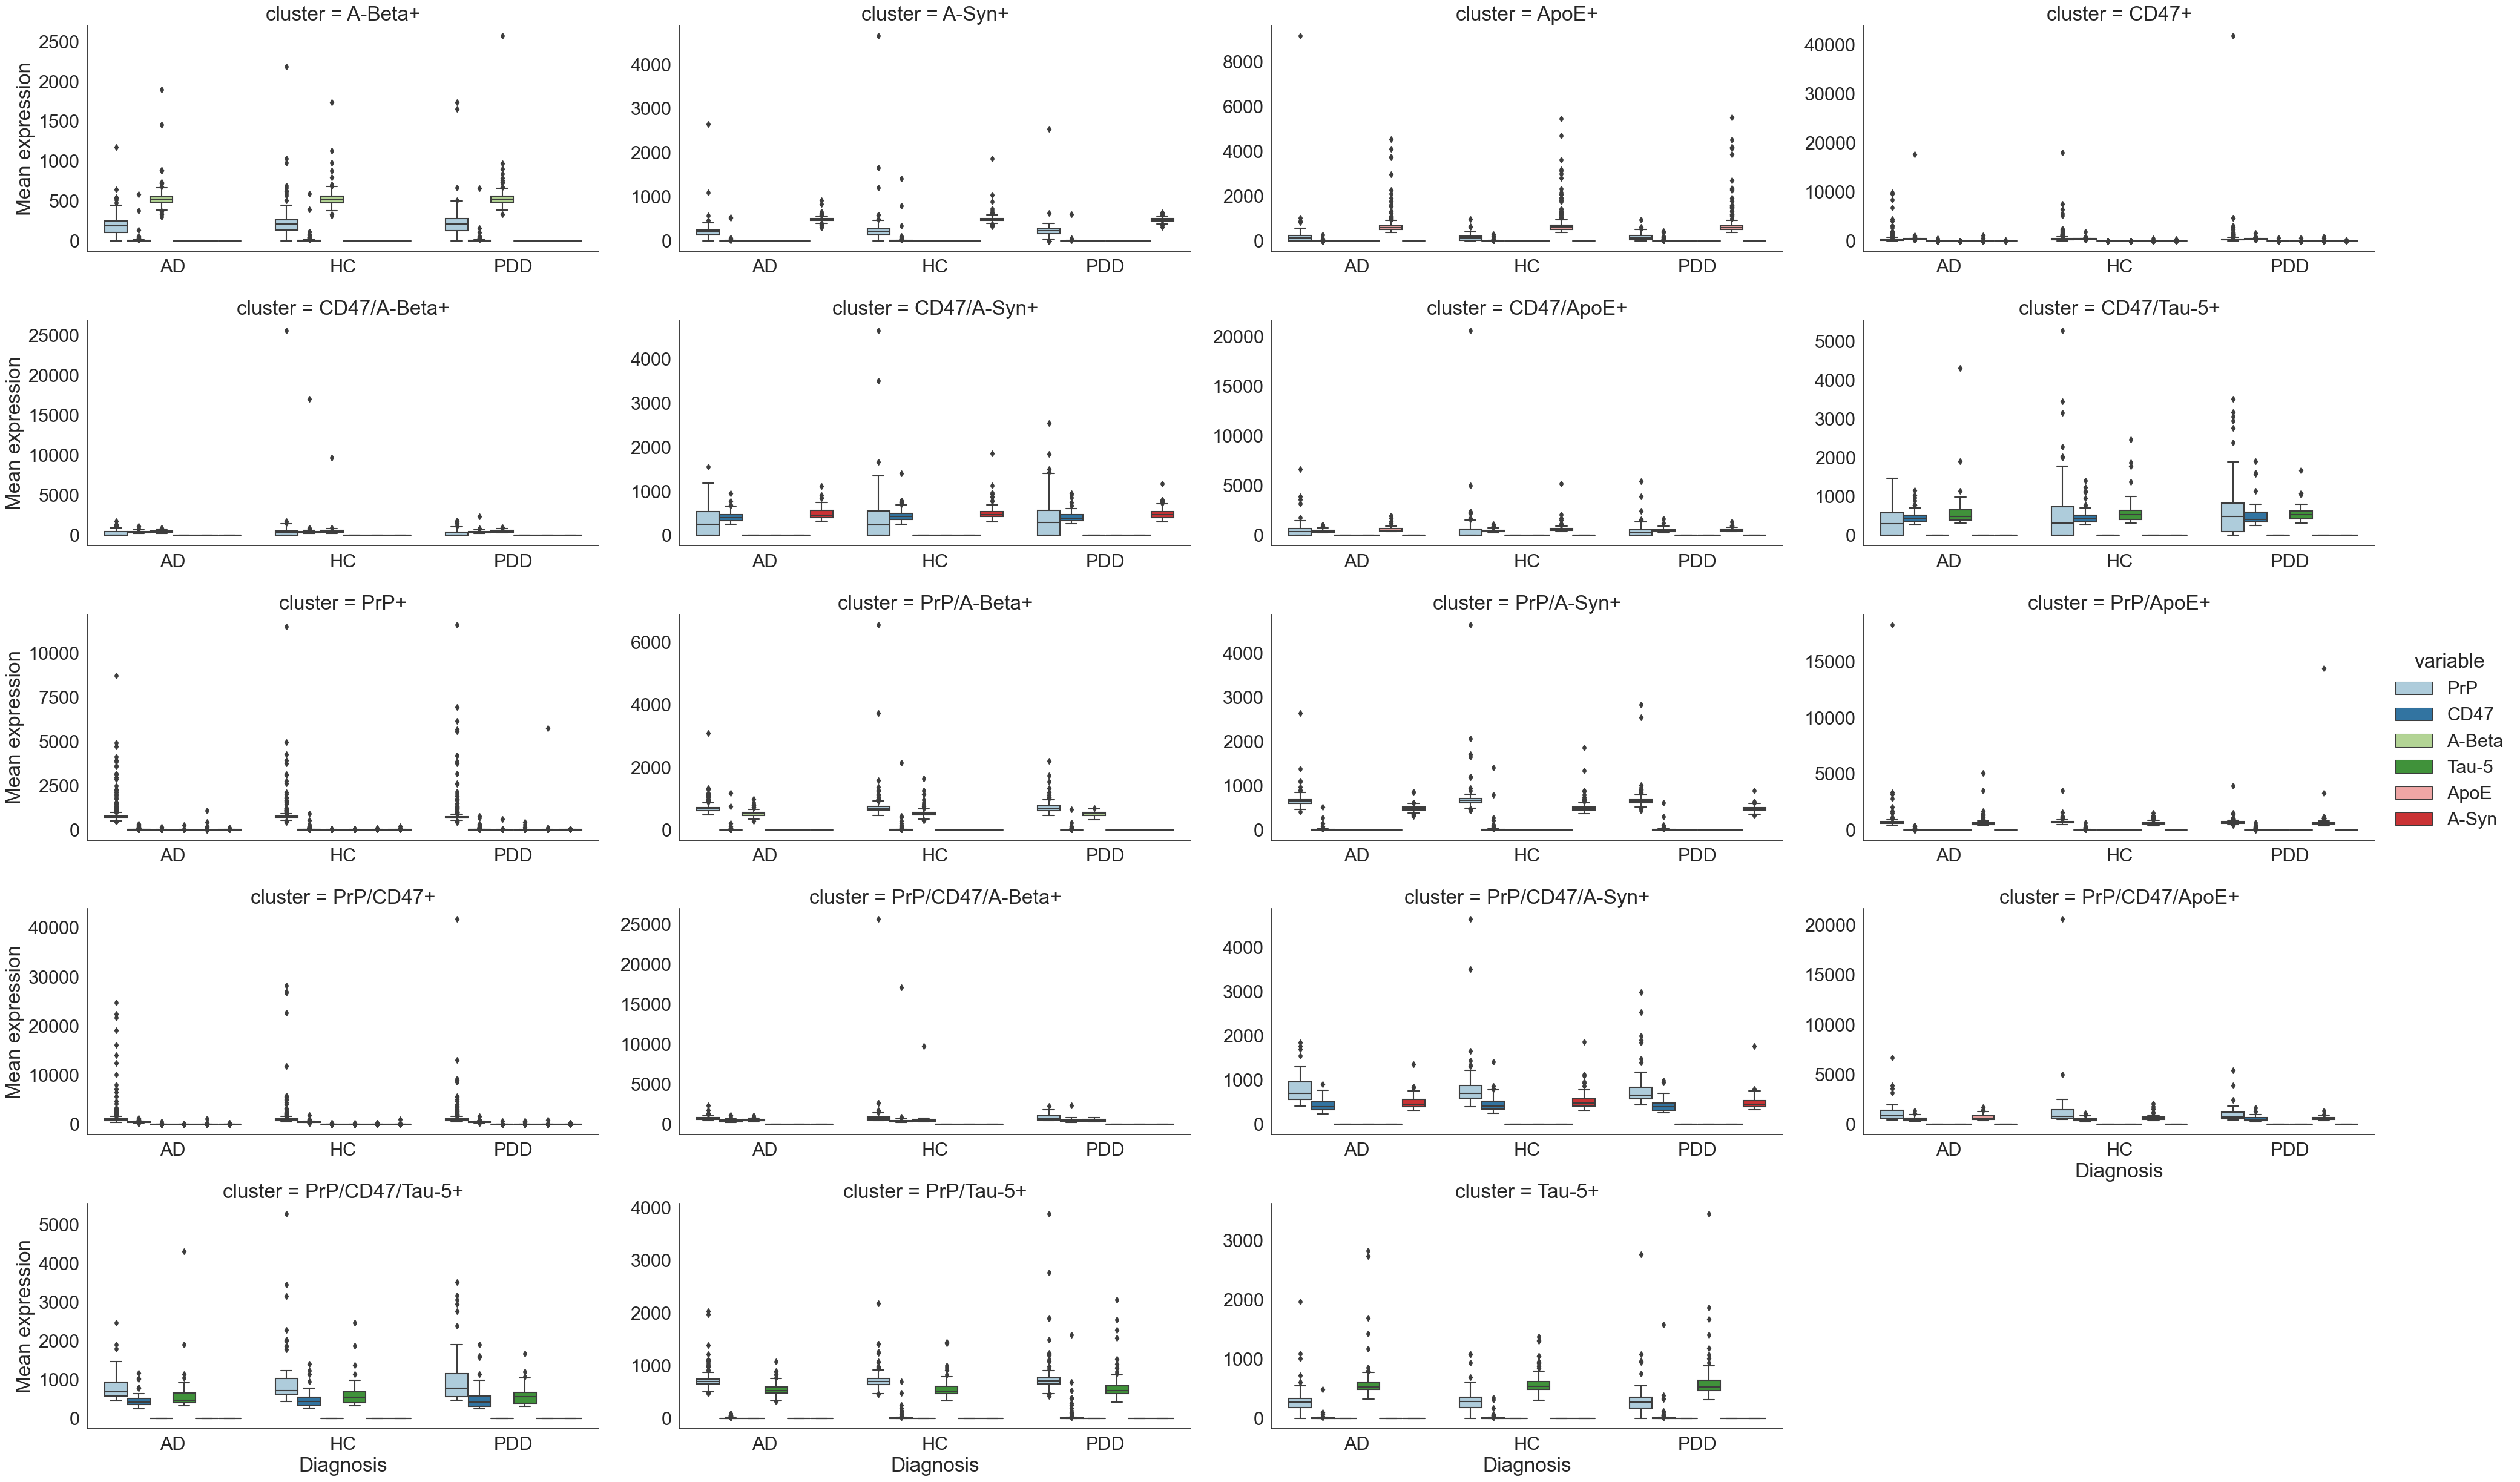

In [203]:
g = sns.catplot(
    data=df_plot, #.loc[df_plt.variable!='PrP', :],
    kind="box",
    x="Diagnosis", y=y, hue="variable",col="cluster",
    col_wrap=4,sharex=False, sharey=False,
    palette="Paired", 
    #alpha=.6, 
    height=5, aspect=2,
)
# g.despine(left=True)
# pairs = [(("MCI", "Tau-5"),( i, "Tau-5")) for i in df_plt.Diagnosis.unique() if i != "MCI"]
# pairs =[]
# for name,ax in g.axes_dict.items():
#     if name =="CD47/PrP/Tau-5+":
#         pairs = [(("MCI", "Tau-5"),( i, "Tau-5")) for i in df_plt.Diagnosis.unique() if i != "MCI"]
#     # elif name =="A-Beta/CD47/PrP+":
#     #     pairs = [(("HC", "Tau-5"),( i, "Tau-5")) for i in df_plt.Diagnosis.unique() if i != "AD"]
#     if len(pairs)>0:
#         print(name)
# # subset the table otherwise the stats were calculated on the whole dataset
#         annot = Annotator(ax, pairs, data=df_plot, x=x, y=y, hue="variable") 
#         annot.configure(test='Mann-Whitney', text_format='star', loc='inside', verbose=2)
#         annot.apply_test().annotate()
#         pairs=[]

In [209]:
coloc_df.marker.unique()

array(['CD63', 'CD81', 'CD9', 'MIgG'], dtype=object)

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

AD vs. HC: Mann-Whitney-Wilcoxon test two-sided, P_val:7.215e-01 U_stat=2.897e+03
HC vs. PDD: Mann-Whitney-Wilcoxon test two-sided, P_val:2.595e-01 U_stat=2.952e+03
AD vs. PDD: Mann-Whitney-Wilcoxon test two-sided, P_val:7.011e-01 U_stat=3.022e+03
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

AD vs. HC: Mann-Whitney-Wilcoxon test two-sided, P_val:5.923e-05 U_stat=2.998e+04
HC vs. PDD: Mann-Whitney-Wilcoxon test two-sided, P_val:9.153e-01 U_stat=3.541e+04
AD vs. PDD: Mann-Whitney-Wilcoxon test two-sided, P_val:1.531e-04 U_stat=2.887e+04
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < 

Text(0.5, 0.98, 'CD9')

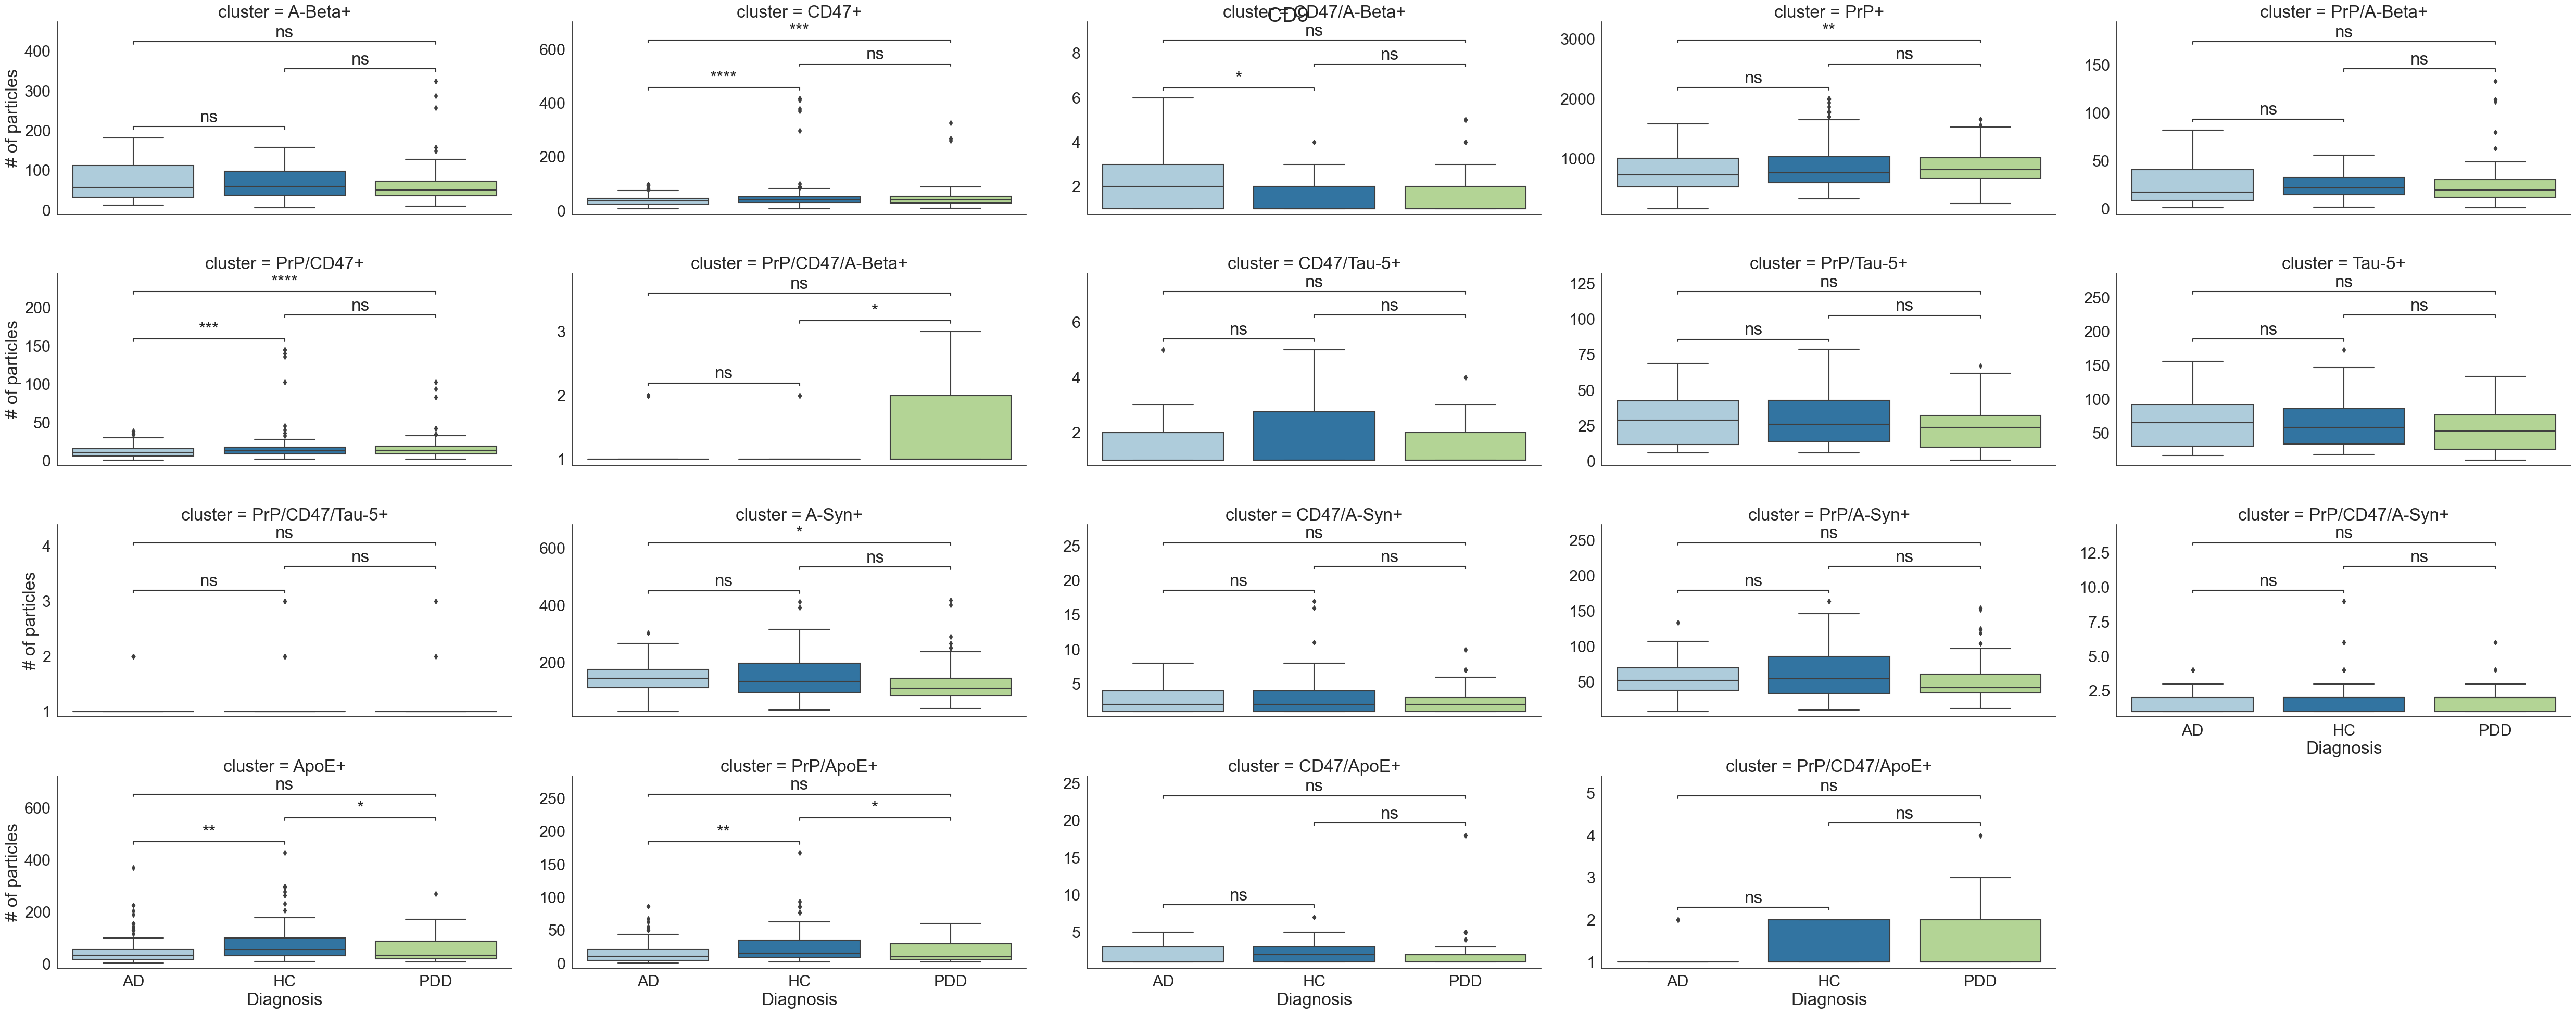

In [210]:
#df_plt = coloc_df.groupby(["cluster", "Diagnosis", "samples", "spot"]).size()#.unstack().fillna(0)
groupby_cols = ['Diagnosis', "panel", 'samples', "cluster", "spot"]
mark = "CD9"
df_plt = coloc_df[coloc_df.marker==mark].groupby(groupby_cols).size().reset_index()
df_plt = df_plt.melt(groupby_cols)
df_plt.head(3)
x="Diagnosis"
sns.set(font_scale=2, style="white")
y="# of particles"
df_plt.rename({"value":y}, axis=1, inplace=True)
# g = sns.catplot(
#     data=df_plt.loc[df_plt.variable=='PrP', :], 
#     kind="bar",
#     x=x, y=y, hue="variable",col="marker",#col_wrap=2,
#     palette="Paired", alpha=.6, height=5, aspect=1.5,
#     #sharex=True,
#     sharey=True,
    
# )
g = sns.catplot(
    data=df_plt, 
    kind="box",
    x=x, y=y,col="cluster",col_wrap=5,
    palette="Paired", #alpha=.6, 
    height=5, aspect=2,
    #sharex=True,
    sharey=False,
    
)
pairs = [("AD", "HC"), ("HC", "PDD"), ("AD", "PDD")]

for name,ax in g.axes_dict.items():
# if True:
#         ax = g.ax
# # subset the table otherwise the stats were calculated on the whole dataset
        tmp = df_plt[df_plt.cluster==name]
        annot = Annotator(ax, pairs, data=tmp, x=x, y=y) 
        annot.configure(test='Mann-Whitney', text_format='star', loc='inside', verbose=2)
        annot.apply_test().annotate()
        
plt.suptitle(mark)

In [206]:
groupby_cols = ['Diagnosis', "panel", 'samples', "cluster", "spot"]
mark = "CD63"
df_plt = coloc_df[coloc_df.marker==mark].groupby(groupby_cols).size().reset_index(level=3).rename({0:"#percluster"}, axis=1)
df_plt = df_plt.join(coloc_df[coloc_df.marker==mark].groupby(['Diagnosis', "panel", 'samples', "spot"]).size().to_frame().rename({0:"#perspot"},axis=1))


df_plt["prop"] = df_plt["#percluster"]/df_plt["#perspot"]
df_plt = df_plt.reset_index()

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

AD vs. HC: Mann-Whitney-Wilcoxon test two-sided, P_val:1.100e-01 U_stat=2.942e+03
HC vs. PDD: Mann-Whitney-Wilcoxon test two-sided, P_val:6.903e-01 U_stat=2.610e+03
AD vs. PDD: Mann-Whitney-Wilcoxon test two-sided, P_val:4.546e-02 U_stat=3.388e+03
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

AD vs. HC: Mann-Whitney-Wilcoxon test two-sided, P_val:1.257e-01 U_stat=3.773e+04
HC vs. PDD: Mann-Whitney-Wilcoxon test two-sided, P_val:3.267e-06 U_stat=4.860e+04
AD vs. PDD: Mann-Whitney-Wilcoxon test two-sided, P_val:1.338e-03 U_stat=4.659e+04
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < 

Text(0.5, 0.98, 'CD63')

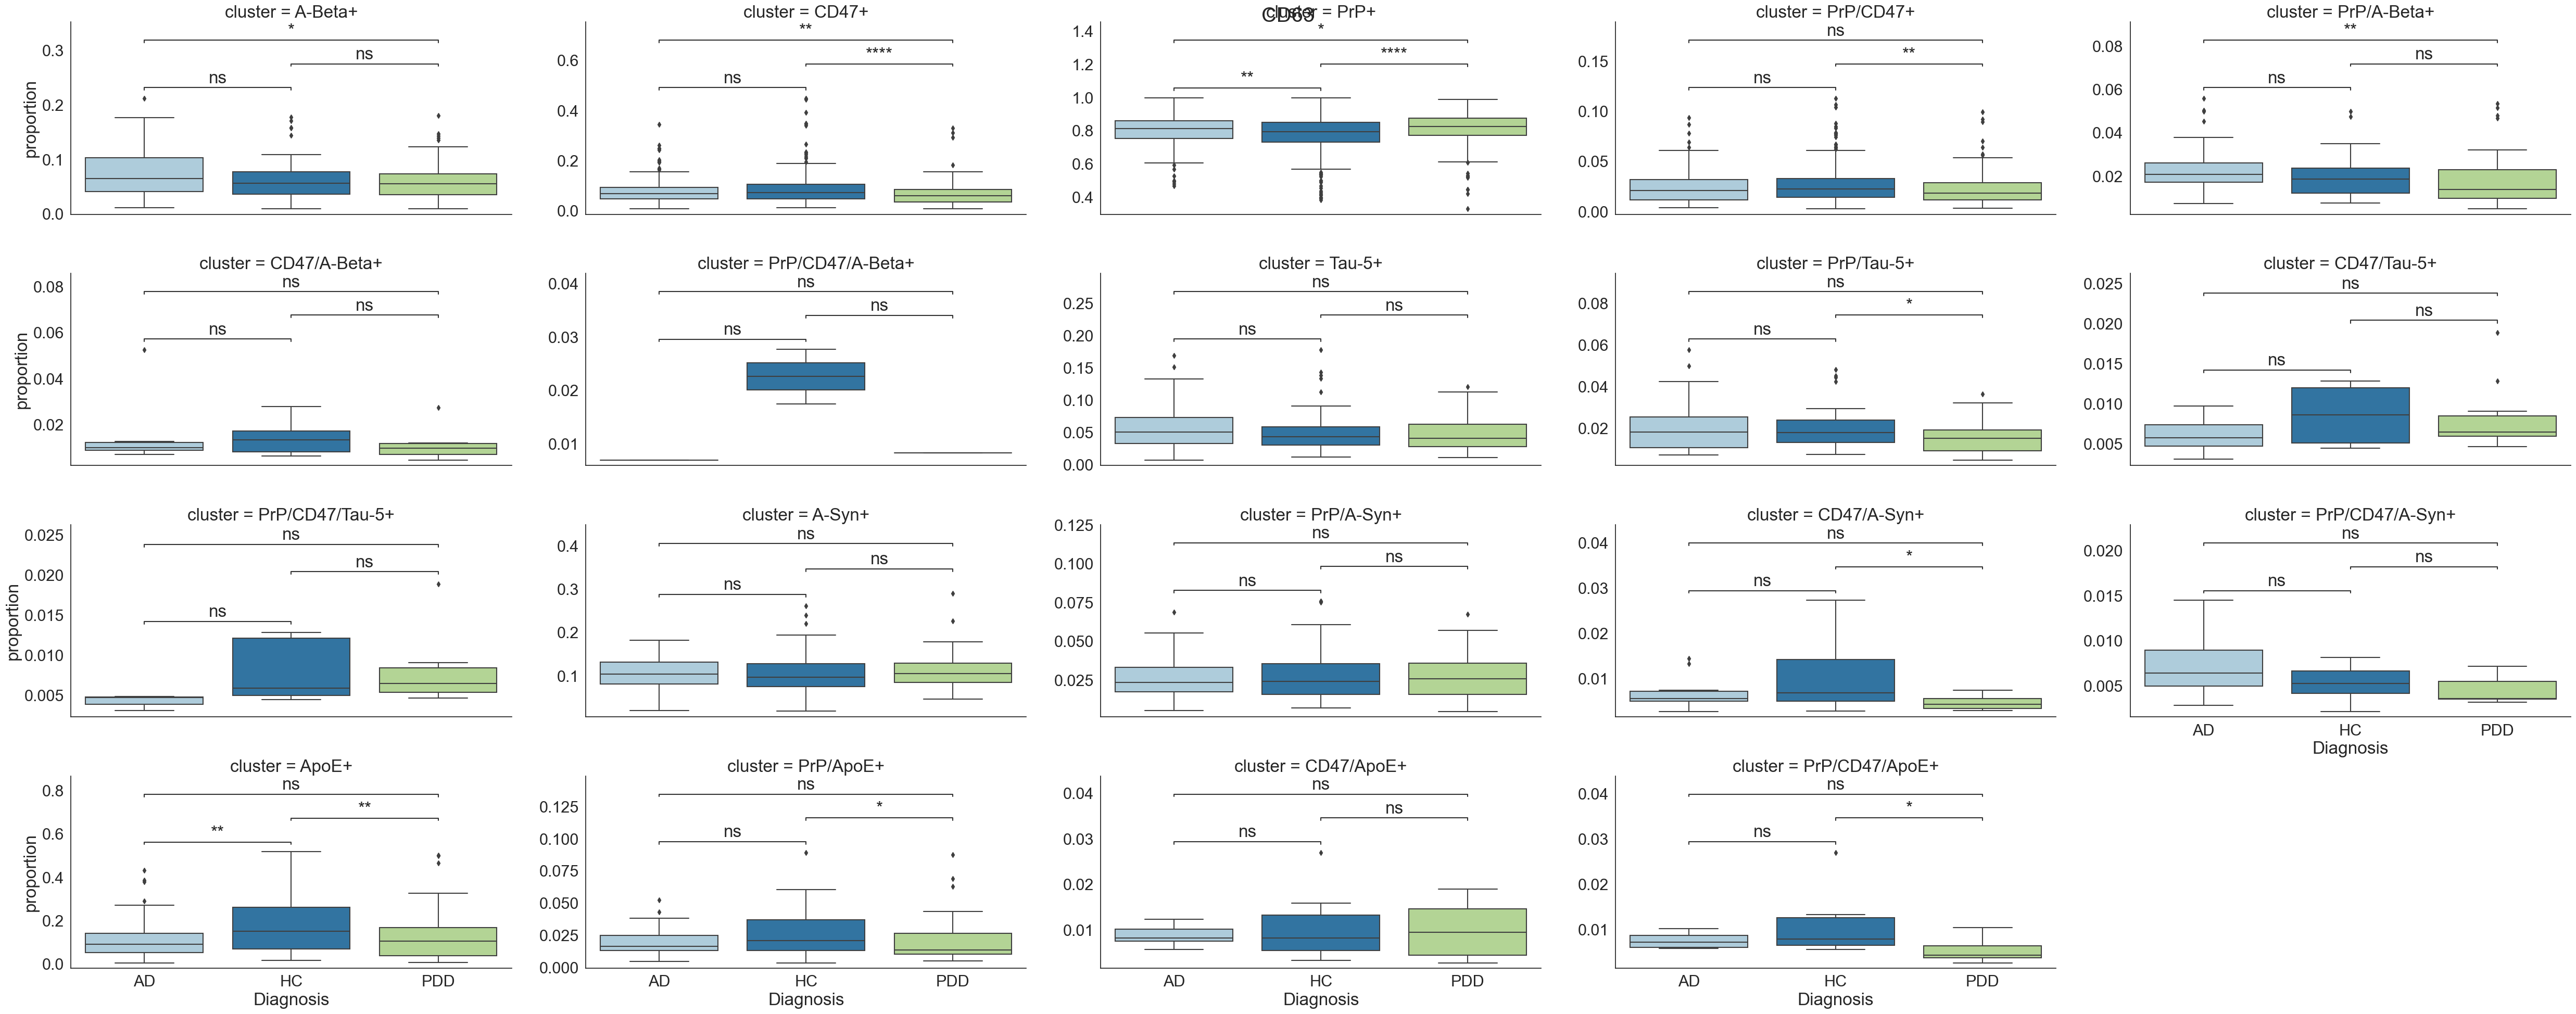

In [207]:
df_plt =df_plt[groupby_cols + ["prop"]].melt(groupby_cols)
df_plt.head(3)
x="Diagnosis"
sns.set(font_scale=2, style="white")
y="proportion"
df_plt.rename({"value":y}, axis=1, inplace=True)
# g = sns.catplot(
#     data=df_plt.loc[df_plt.variable=='PrP', :], 
#     kind="bar",
#     x=x, y=y, hue="variable",col="marker",#col_wrap=2,
#     palette="Paired", alpha=.6, height=5, aspect=1.5,
#     #sharex=True,
#     sharey=True,
    
# )
g = sns.catplot(
    data=df_plt, 
    kind="box",
    x=x, y=y,col="cluster",col_wrap=5,
    palette="Paired", #alpha=.6, 
    height=5, aspect=2,
    #sharex=True,
    sharey=False,
    
)
pairs = [("AD", "HC"), ("HC", "PDD"), ("AD", "PDD")]

for name,ax in g.axes_dict.items():
# if True:
#         ax = g.ax
# # subset the table otherwise the stats were calculated on the whole dataset
        tmp = df_plt[df_plt.cluster==name]

        annot = Annotator(ax, pairs, data=tmp, x=x, y=y) 
        annot.configure(test='Mann-Whitney', text_format='star', loc='inside', verbose=2)
        annot.apply_test().annotate()
        
plt.suptitle(mark)